# ARIMA Forecast Implementation

One of the methods available in Python to model and predict future points of a
time series is known as `SARIMAX`, which stands for Seasonal AutoRegressive
Integrated Moving Averages with eXogenous regressors.

The primarily focus of this implementation lies on the ARIMA component, which
is used to fit time-series data to better understand and forecast future points
of time series.

In [ ]:
# importing common libs
import itertools
import warnings
warnings.filterwarnings("ignore")

# importing statistical libs
import pandas as pd
import numpy as np
import statsmodels.api as sm

# importing visualization libs
import matplotlib.pyplot as plt
plt.style.use('seaborn-deep')

# setting chart defaults
x_label = 'Date'
y_label = 'CO2 Levels'
fig_size = (14, 8)
pred_start_str = '1998-01-01'
pred_start = pd.to_datetime(pred_start_str)

In [ ]:
# loading the data
data = sm.datasets.co2.load_pandas()
y = data.data

The ``statsmodel`` CO2 sample dataset was chosen to test the forecast model, as legal
obligations prohibit me from using our real-world IT service data. 

The data is preprocessed before being used in model. Monthly averages are used
for modes as weekly data are tricky to work with since it’s a brief amount of time.
This conversion is performed with the `resample` function. For simplicity, the
`fillna()` function is used to ensure that there are no missing values
in time series. The term `bfill` function is used to use the value before
filling in missing values.

In [3]:
# resampling and cleaning the data
y = y['co2'].resample('MS').mean()
y = y.fillna(y.bfill())

print(y)

1958-03-01    316.100000
1958-04-01    317.200000
1958-05-01    317.433333
1958-06-01    315.625000
1958-07-01    315.625000
1958-08-01    314.950000
1958-09-01    313.500000
1958-10-01    313.425000
1958-11-01    313.425000
1958-12-01    314.700000
1959-01-01    315.500000
1959-02-01    316.700000
1959-03-01    316.733333
1959-04-01    317.675000
1959-05-01    318.325000
1959-06-01    318.025000
1959-07-01    316.525000
1959-08-01    314.900000
1959-09-01    313.825000
1959-10-01    313.400000
1959-11-01    314.875000
1959-12-01    315.525000
1960-01-01    316.380000
1960-02-01    316.975000
1960-03-01    317.575000
1960-04-01    319.120000
1960-05-01    319.925000
1960-06-01    319.450000
1960-07-01    318.060000
1960-08-01    315.775000
                 ...    
1999-07-01    369.000000
1999-08-01    366.700000
1999-09-01    364.675000
1999-10-01    365.140000
1999-11-01    366.650000
1999-12-01    367.900000
2000-01-01    369.020000
2000-02-01    369.375000
2000-03-01    370.400000


Some distinguishable patterns appear when the data is plotted. The time series
has a very obvious seasonality pattern and overall increasing trend.

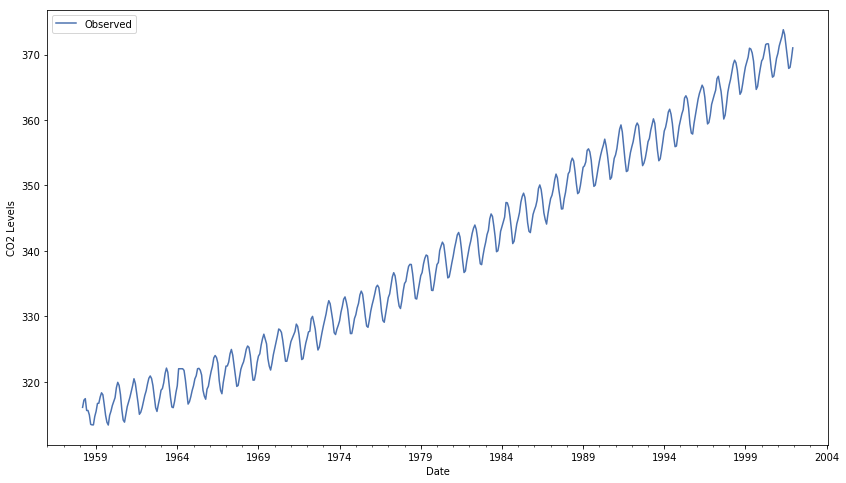

In [4]:
# Observed data
ax = y.plot(label='Observed', figsize=fig_size)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
plt.legend()
plt.show()

## Finding Optimal ARIMA Model Parameters

To fit time series dataset with a seasonal ARIMA model, the first goal is to
find the values of `ARIMA(p,d,q)(P,D,Q)s` that optimize a metric of our
interest. There are many guidelines and best practices to achieve this goal,
yet the correct parametrization of ARIMA models can be a painstaking manual
process that requires expertise and time.

Other statistical programming languages such as R provide automated ways
to solve this issue, but those have yet to be ported over to Python.This issue
is resolved by Python code that programmatically select the optimal parameter
values for the `ARIMA(p,d,q)(P,D,Q)s` time series model.

A "grid search" is used to iteratively explore different combinations of
parameters. For each combination of parameters, a new seasonal ARIMA
model is wit with the `SARIMAX()` function from the `statsmodels` module and
its overall quality is assesed. Once the entire set of parameters is explored,
the most optimal set of parameters will be the one that provides the best performance
for our criteria.

Following list shows generated values from various combination of parameters
that were assessed.

In [5]:
# Define the p, d and q parameters as integers between 0 and 2
p = d = q = range(0, 2)
# Generate all combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))
# Generate all combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in \
                list(itertools.product(p, d, q))]

print('Examples of parameter combinations for SARIMA ...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for SARIMA ...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


The triplets of parameters defined above can be used to automate the process
of training and evaluating ARIMA models using different combinations. In
Statistics and Machine Learning, this process is known as grid search (or
hyperparameter optimization) for model selection.

When evaluating and comparing statistical models fitted with different
parameters, each can be ranked against one another based on how well it fits
the data or its ability to accurately predict future data points. We will use
the `AIC` (Akaike Information Criterion) value, which is conveniently returned
with ARIMA models fitted using `statsmodels`. The `AIC` measures how well a model
fits the data while taking in account the overall complexity of the model. A
model that fits the data very well while using lots of features will be
assigned a larger `AIC` score than a model that uses fewer features to achieve
the same goodness-of-fit. Therefore, we are interested in finding the model
that yields the lowest `AIC` value.

The code below iterates through combinations of parameters and uses the
`SARIMAX` function from `statsmodels` module to fit the corresponding Seasonal
ARIMA model. The `order` argument specifies the `(p, d, q)` parameters, while
the `seasonal_order` argument specifies the `(P, D, Q, S)` seasonal component
of the Seasonal ARIMA model. After fitting each `SARIMAX()` model, the code
prints respective AIC scores.

In [6]:
warnings.filterwarnings("ignore")

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(
                y,
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = mod.fit()

            print('SARIMAX{}x{}12 - AIC: {}'.format(
                param, param_seasonal, results.aic))
        except:
            continue

SARIMAX(0, 0, 0)x(0, 0, 1, 12)12 - AIC: 6787.34362404
SARIMAX(0, 0, 0)x(0, 1, 1, 12)12 - AIC: 1596.71117276
SARIMAX(0, 0, 0)x(1, 0, 0, 12)12 - AIC: 1058.93889213
SARIMAX(0, 0, 0)x(1, 0, 1, 12)12 - AIC: 1056.28784503
SARIMAX(0, 0, 0)x(1, 1, 0, 12)12 - AIC: 1361.65789777
SARIMAX(0, 0, 0)x(1, 1, 1, 12)12 - AIC: 1044.76479127
SARIMAX(0, 0, 1)x(0, 0, 0, 12)12 - AIC: 6881.04875423
SARIMAX(0, 0, 1)x(0, 0, 1, 12)12 - AIC: 6072.66232764
SARIMAX(0, 0, 1)x(0, 1, 0, 12)12 - AIC: 1379.19410669
SARIMAX(0, 0, 1)x(0, 1, 1, 12)12 - AIC: 1241.41747169
SARIMAX(0, 0, 1)x(1, 0, 0, 12)12 - AIC: 1081.7115906
SARIMAX(0, 0, 1)x(1, 0, 1, 12)12 - AIC: 780.431283516
SARIMAX(0, 0, 1)x(1, 1, 0, 12)12 - AIC: 1119.59578936
SARIMAX(0, 0, 1)x(1, 1, 1, 12)12 - AIC: 807.091298807
SARIMAX(0, 1, 0)x(0, 0, 1, 12)12 - AIC: 1240.22111992
SARIMAX(0, 1, 0)x(0, 1, 1, 12)12 - AIC: 337.793854886
SARIMAX(0, 1, 0)x(1, 0, 0, 12)12 - AIC: 619.950175922
SARIMAX(0, 1, 0)x(1, 0, 1, 12)12 - AIC: 376.928376007
SARIMAX(0, 1, 0)x(1, 1, 0, 12

Because some parameter combinations may lead to numerical misspecifications,
warning messages are explicitly disabled in order to avoid an overload of
warning messages. These misspecifications can also lead to errors and throw an
exception, so we make sure to catch these exceptions and ignore the parameter
combinations that cause these issues.

## Fitting ARIMA Time Series Model

Set of parameters that produces the best fitting model to our time series data
were identified using the grid search. We can proceed to analyze this
particular model in more depth. Now, the optimal parameter values are inputted
into a new `SARIMAX` model.

In [7]:
mod = sm.tsa.statespace.SARIMAX(
    y,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12),
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = mod.fit()

print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3183      0.092      3.443      0.001       0.137       0.499
ma.L1         -0.6255      0.077     -8.167      0.000      -0.776      -0.475
ar.S.L12       0.0010      0.001      1.732      0.083      -0.000       0.002
ma.S.L12      -0.8769      0.026    -33.808      0.000      -0.928      -0.826
sigma2         0.0972      0.004     22.633      0.000       0.089       0.106


The summary attribute that results from the output of `SARIMAX` returns a
significant amount of information, but we'll focus our attention on the table
of coefficients. The `coef` column shows the weight (i.e. importance) of each
feature and how each one impacts the time series. The `P>|z|` column informs us
of the significance of each feature weight. Here, each weight has a p-value
lower or close to `0.05`, so it is reasonable to retain all of them in our
model.

When fitting seasonal `ARIMA` models (and any other models for that matter), it
is important to run model diagnostics to ensure that none of the assumptions
made by the model have been violated. The `plot_diagnostics` object allows us to
quickly generate model diagnostics and investigate for any unusual behavior.


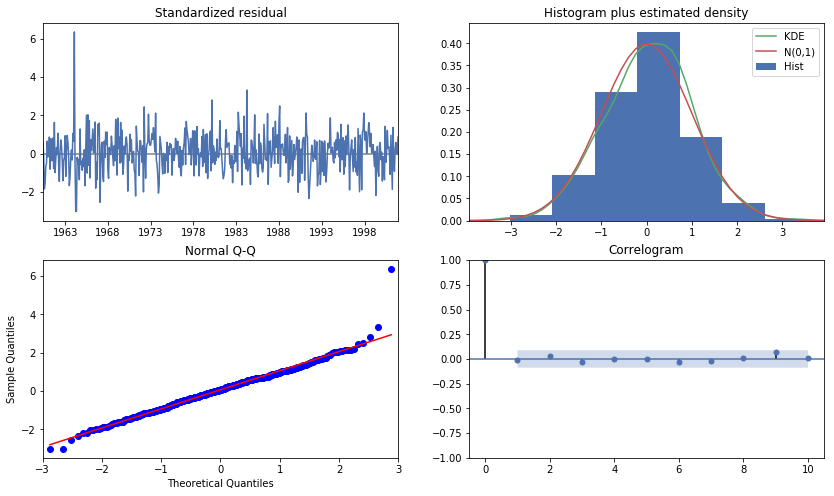

In [8]:
results.plot_diagnostics(figsize=fig_size)
plt.show()


The primary concern is to ensure that the residuals of our model are
uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA
model does not satisfy these properties, it is a good indication that model can
be further improved.

In this case, model diagnostics suggests that the model residuals are normally
distributed based on the following:

* In the top right plot, we see that the red KDE line follows closely with the
  `N(0,1)` line (where `N(0,1)`) is the standard notation for a normal
  distribution with mean 0 and standard deviation of 1). This is a good
  indication that the residuals are normally distributed.

* The qq-plot on the bottom left shows that the ordered distribution of
  residuals (blue dots) follows the linear trend of the samples taken from a
  standard normal distribution with `N(0, 1)`. Again, this is a strong indication
  that the residuals are normally distributed.

* The residuals over time (top left plot) don't display any obvious seasonality
  and appear to be white noise. This is confirmed by the autocorrelation (i.e.
  correlogram) plot on the (bottom right), which shows that the time series
  residuals have low correlation with lagged versions of itself. Those
  observations lead us to conclude that our model produces a satisfactory fit
  that could help us understand our time series data and forecast future values.

Although we have a satisfactory fit, some parameters of our seasonal ARIMA
model could be changed to improve our model fit. For example, our grid search
only considered a restricted set of parameter combinations, so we may find
better models if we widened the grid search.

## Validating ARIMA Model

The model for given time series is now ready. It can be used to produce
forecasts. Now the comparison of predicted values to real values of the time
series will help to understand the accuracy of the forecasts. The
`get_prediction()` and `conf_int()` attributes allow to obtain the values and
associated confidence intervals for forecasts of the time series.


In [9]:
pred = results.get_prediction(start=pred_start, dynamic=False)
pred_ci = pred.conf_int()

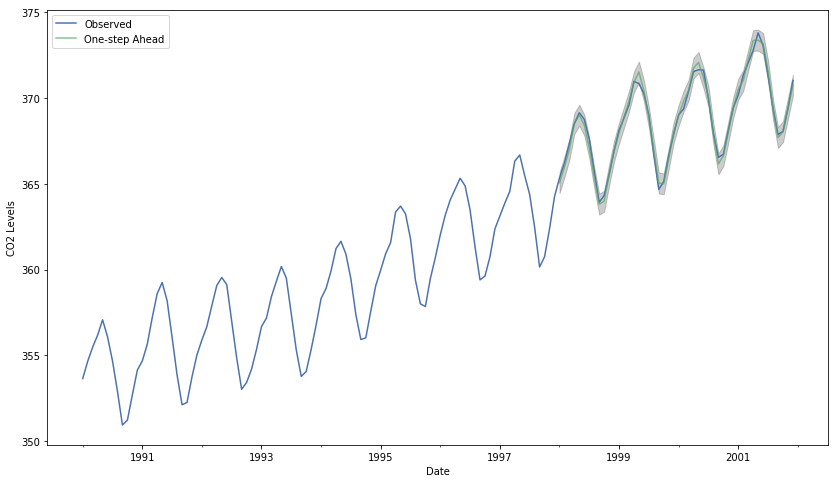

In [10]:
ax = y['1990':].plot(label='Observed', figsize=fig_size)
pred.predicted_mean.plot(ax=ax, label='One-step Ahead', alpha=.7)
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
plt.legend()
plt.show()

The forecasts align with the true values very well, showing an overall
increase trend.

It is also useful to quantify the accuracy of our forecasts. The MSE (Mean
Squared Error) summarizes the average error of our forecasts. distance to the
true value is computed for each predicted value and the result is squared. The
results need to be squared so that positive/negative differences do not cancel
each other out when the overall mean is computed.

In [11]:
y_forecasted = pred.predicted_mean
y_truth = y[pred_start_str:]

# Compute the mean square error
mse = round(((y_forecasted - y_truth) ** 2).mean(), 2)
print('The Mean Squared Error of forecasts is {}'.format(mse))

The Mean Squared Error of forecasts is 0.07


The MSE of our one-step ahead forecasts yields a value of **0.07**, which is very
low as it is close to 0. An MSE of 0 would that the estimator is predicting
observations of the parameter with perfect accuracy, which would be an ideal
scenario but it not typically possible.

However, a better representation of our true predictive power can be obtained
using dynamic forecasts. In this case, we only use information from the time
series up to a certain point, and after that, forecasts are generated using
values from previous forecasted time points.

Plotting the observed and forecasted values of the time series, we see that
the overall forecasts are accurate even when using dynamic forecasts. All
forecasted values (red line) match pretty closely to the ground truth (blue
line), and are well within the confidence intervals of our forecast.

In [12]:
pred_dynamic = results.get_prediction(start=pred_start,\
                                      dynamic=True, \
                                      full_results=True)
pred_dynamic_ci = pred_dynamic.conf_int()

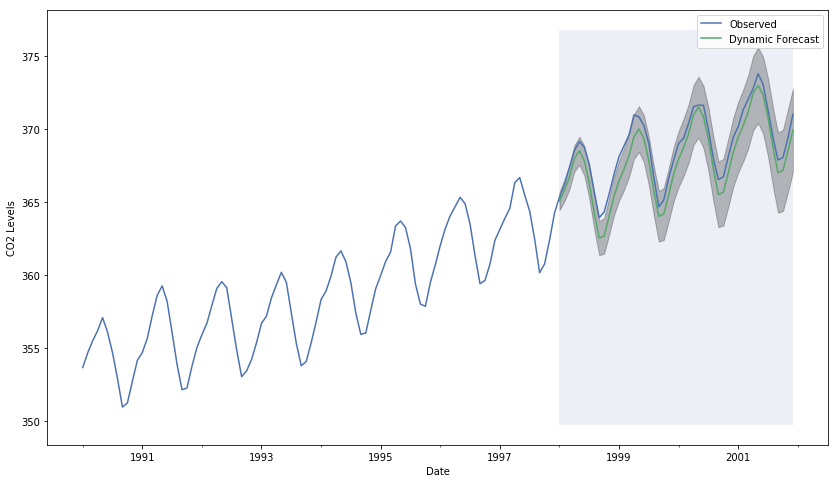

In [13]:
ax = y['1990':].plot(label='Observed', figsize=fig_size)
pred_dynamic.predicted_mean.plot(label='Dynamic Forecast', ax=ax)

ax.fill_between(pred_dynamic_ci.index,
                pred_dynamic_ci.iloc[:, 0],
                pred_dynamic_ci.iloc[:, 1], color='k', alpha=.25)

ax.fill_betweenx(ax.get_ylim(), pred_start, y.index[-1],
                 alpha=.1, zorder=-1)

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

plt.legend()
plt.show()

The predictive performance of the forecasts is quantified by computing its MSE.

In [14]:
# Extract the predicted and true values of our time series
y_forecasted = pred_dynamic.predicted_mean
y_truth = y['1998-01-01':]

# Compute the mean square error
mse = round(((y_forecasted - y_truth) ** 2).mean(), 2)
print('The Mean Squared Error of forecasts is {}'.format(mse))

The Mean Squared Error of forecasts is 1.01


## Creating ARIMA Model Forecasts

Last part of implementation describes how to leverage seasonal ARIMA time series model to forecast
future values. The `get_forecast()` attribute of time series object can compute
forecasted values for a specified number of steps ahead.

In [15]:
# Get forecast 500 steps ahead in future
pred_uc = results.get_forecast(steps=500)
# Get confidence intervals of forecasts
pred_ci = pred_uc.conf_int()

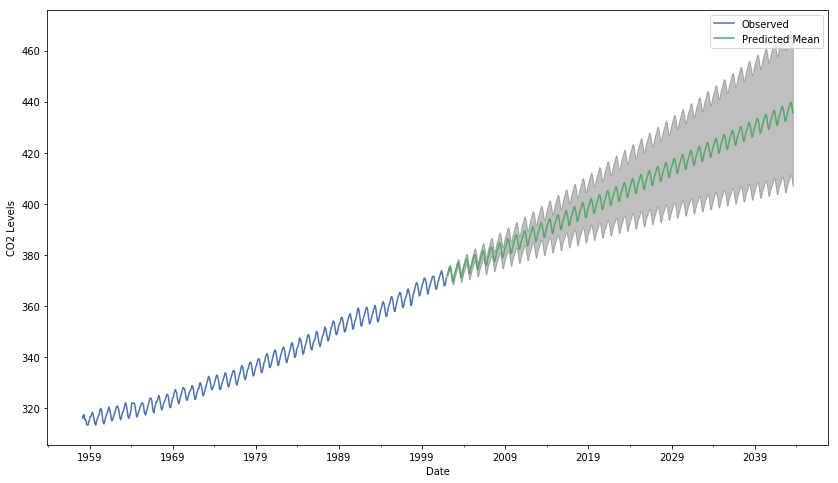

In [16]:
ax = y.plot(label='Observed', figsize=fig_size)
pred_uc.predicted_mean.plot(ax=ax, label='Predicted Mean')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
plt.legend()
plt.show()

As the forecast goes further out into the future, it provides less confident
values. This is reflected by the confidence intervals generated by the model,
which grow larger as we go further into the future.